In [15]:
import pandas as pd
import re


In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [19]:
df=pd.read_csv("FinalBalancedDataset.csv")

In [20]:

print(df.columns)
print(df.head())

Index(['Unnamed: 0', 'Toxicity', 'tweet'], dtype='object')
   Unnamed: 0  Toxicity                                              tweet
0           0         0   @user when a father is dysfunctional and is s...
1           1         0  @user @user thanks for #lyft credit i can't us...
2           2         0                                bihday your majesty
3           3         0  #model   i love u take with u all the time in ...
4           4         0             factsguide: society now    #motivation


In [21]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [22]:
# GENERATING WORD CLOUDs FOR ALL THE TOXIC WORDS AND ALL THE UNTOXIC WORDS
# This is to get a better understanding of the overall data

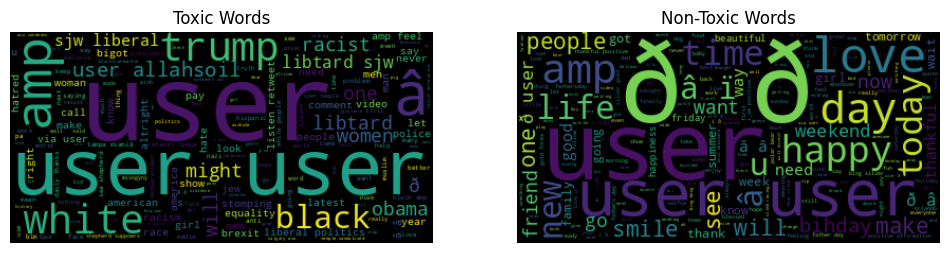

In [23]:
# getting a list of all the words in a toxic tweet and in a non-toxic tweet seperately
allToxicWords=' '.join(df[df['Toxicity']==1]['tweet'])
allNonToxicWords=' '.join(df[df['Toxicity']==0]['tweet'])
toxic_wordcloud = WordCloud().generate(allToxicWords)
non_toxic_wordcloud = WordCloud().generate(allNonToxicWords)
# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Toxic Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Words')
plt.axis('off')

plt.show()


In [24]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [28]:
## defining a function to clean the data which we will pass through as tweets

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to form cleaned text
    cleaned_text = ' '.join(tokens)
    return cleaned_text


df['cleaned_tweet'] = df['tweet'].apply(clean_text)

In [29]:
df['cleaned_tweet']


0        user father dysfunctional selfish drag kid dys...
1        user user thanks lyft credit cant use cause do...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
10699    scientific fact happiness never knew healthy mind
10700                     nobody clicked tag see going lol
10701                         family time move bodyandsoul
10702    user hbd amazing sophia bc barely pix together...
10703                                         user know yo
Name: cleaned_tweet, Length: 10704, dtype: object

In [30]:
## making a similar word cloud after text cleaning to notice any differnces

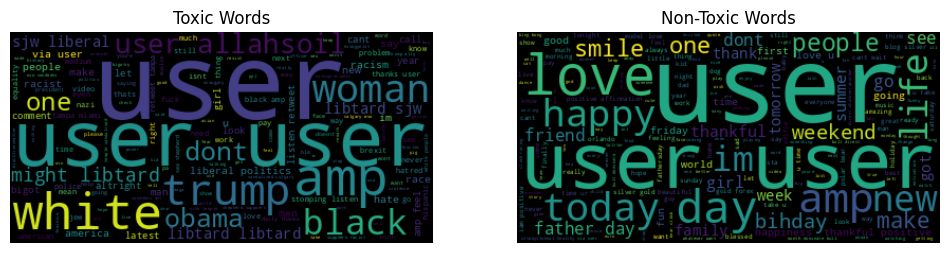

In [31]:
toxic_words = ' '.join(df[df['Toxicity'] == 1]['cleaned_tweet'])
non_toxic_words = ' '.join(df[df['Toxicity'] == 0]['cleaned_tweet'])

toxic_wordcloud = WordCloud().generate(toxic_words)
non_toxic_wordcloud = WordCloud().generate(non_toxic_words)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Toxic Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Words')
plt.axis('off')

plt.show()

In [32]:
df.shape

(10704, 3)

In [33]:
## splitting the data

In [34]:
X_train,X_test,y_train,y_test=train_test_split(df['cleaned_tweet'][:25000],df['Toxicity'][:25000],random_state=42,train_size=0.8)

In [35]:
X_train.shape

(8563,)

In [36]:
# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [37]:
def generate_metrics(y_true, y_pred_probs, model_name):
    y_pred = (y_pred_probs >= 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"{model_name} Metrics:\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")
    return precision, recall, f1, roc_auc

# Train and predict for Bag of Words and TF-IDF
metrics_list = []
def model_specific_metrics(model_name,model):
    # Bag of Words
    model.fit(X_train_bow, y_train)
    predictions_bow = model.predict_proba(X_test_bow)[:, 1]
    precision_bow, recall_bow, f1_bow, roc_auc_bow = generate_metrics(y_test, predictions_bow, model_name + ' (Bag of Words)')
    metrics_list.append((model_name + ' (Bag of Words)', precision_bow, recall_bow, f1_bow, roc_auc_bow))

    # TF-IDF
    model.fit(X_train_tfidf, y_train)
    predictions_tfidf = model.predict_proba(X_test_tfidf)[:, 1]
    precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf = generate_metrics(y_test, predictions_tfidf, model_name + ' (TF-IDF)')
    metrics_list.append((model_name + ' (TF-IDF)', precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf))



FOR Decision Tree

In [38]:
dt=DecisionTreeClassifier()
model_specific_metrics('Decision Tree',dt)

Decision Tree (Bag of Words) Metrics:
Precision: 0.64, Recall: 0.55, F1-score: 0.59, ROC-AUC: 0.76
Decision Tree (TF-IDF) Metrics:
Precision: 0.51, Recall: 0.48, F1-score: 0.50, ROC-AUC: 0.73


In [39]:
## FOR Random FOrest

In [40]:
rf=RandomForestClassifier()
model_specific_metrics('Random Forest',rf)

Random Forest (Bag of Words) Metrics:
Precision: 0.79, Recall: 0.33, F1-score: 0.46, ROC-AUC: 0.91
Random Forest (TF-IDF) Metrics:
Precision: 0.80, Recall: 0.32, F1-score: 0.46, ROC-AUC: 0.89


In [41]:
## For naive bayes

In [42]:
nb=MultinomialNB()
model_specific_metrics("Naive Bayes",nb)

Naive Bayes (Bag of Words) Metrics:
Precision: 0.88, Recall: 0.39, F1-score: 0.54, ROC-AUC: 0.91
Naive Bayes (TF-IDF) Metrics:
Precision: 1.00, Recall: 0.05, F1-score: 0.10, ROC-AUC: 0.89


In [43]:
# KNN

In [44]:
knn=KNeighborsClassifier()
model_specific_metrics("KNeighborsClassifier",knn)


KNeighborsClassifier (Bag of Words) Metrics:
Precision: 0.89, Recall: 0.06, F1-score: 0.11, ROC-AUC: 0.64
KNeighborsClassifier (TF-IDF) Metrics:
Precision: 1.00, Recall: 0.06, F1-score: 0.11, ROC-AUC: 0.75


In [62]:
svm=SVC(probability=True)
model_specific_metrics("SVM",svm)

SVM (Bag of Words) Metrics:
Precision: 0.80, Recall: 0.49, F1-score: 0.61, ROC-AUC: 0.92
SVM (TF-IDF) Metrics:
Precision: 0.74, Recall: 0.56, F1-score: 0.63, ROC-AUC: 0.93


In [63]:
metrics_list

[('Decision Tree (Bag of Words)',
  0.6379310344827587,
  0.5481481481481482,
  0.5896414342629483,
  0.7636054798567262),
 ('Decision Tree (TF-IDF)',
  0.5118110236220472,
  0.48148148148148145,
  0.4961832061068702,
  0.7252871016579889),
 ('Random Forest (Bag of Words)',
  0.7857142857142857,
  0.32592592592592595,
  0.46073298429319376,
  0.9110667996011964),
 ('Random Forest (TF-IDF)',
  0.7962962962962963,
  0.31851851851851853,
  0.4550264550264551,
  0.892304567778147),
 ('Naive Bayes (Bag of Words)',
  0.8813559322033898,
  0.3851851851851852,
  0.5360824742268041,
  0.9050515121302758),
 ('Naive Bayes (TF-IDF)',
  1.0,
  0.05185185185185185,
  0.09859154929577466,
  0.8878143347734574),
 ('KNeighborsClassifier (Bag of Words)',
  0.8888888888888888,
  0.05925925925925926,
  0.11111111111111112,
  0.6369207193235109),
 ('KNeighborsClassifier (TF-IDF)',
  1.0,
  0.05925925925925926,
  0.11188811188811189,
  0.7515195155274917),
 ('SVM (Bag of Words)',
  0.8048780487804879,
  0.4

In [64]:
## Generating a metric dataset for easy plotting and comparison for each model

In [65]:
metrics_df = pd.DataFrame(metrics_list, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
metrics_df['Vectorization'] = ['Bag of Words' if 'Bag of Words' in model else 'TF-IDF' for model in metrics_df['Model']]


In [66]:
## function to plot bar graphs
def generate_bar_chart(metrics_list, metric_name):
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y=metric_name, hue='Vectorization', data=metrics_list)
    plt.xticks(rotation=45)
    plt.title(f'{metric_name} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.savefig(f'{metric_name.lower()}_bar_chart.pdf')
    plt.show()
    plt.close()

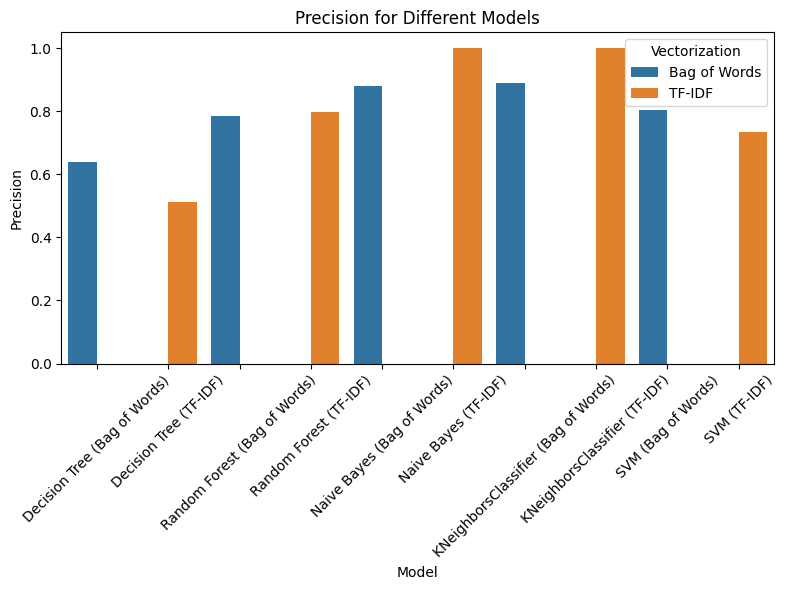

In [67]:
## to generate the precision graph for a comparison
generate_bar_chart(metrics_df, 'Precision')



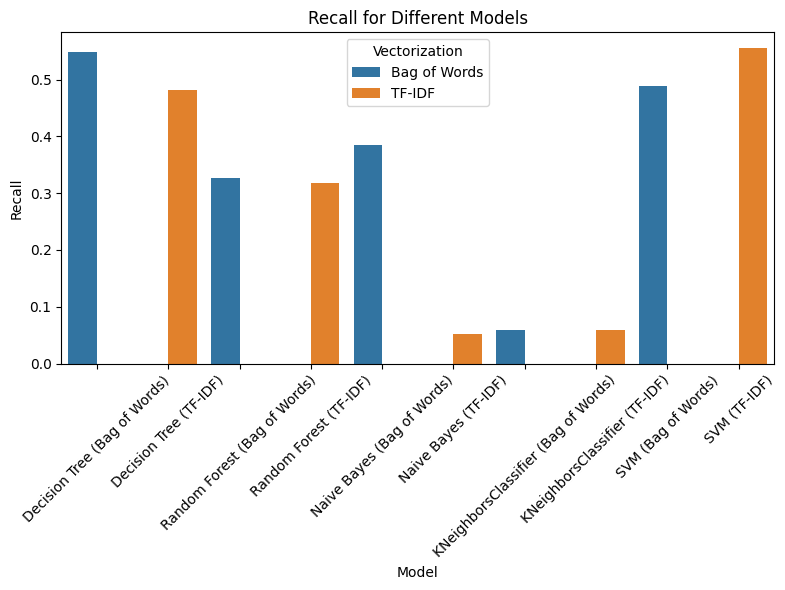

In [68]:
## to generate a recall graph for comparison amonf the model
generate_bar_chart(metrics_df, 'Recall')

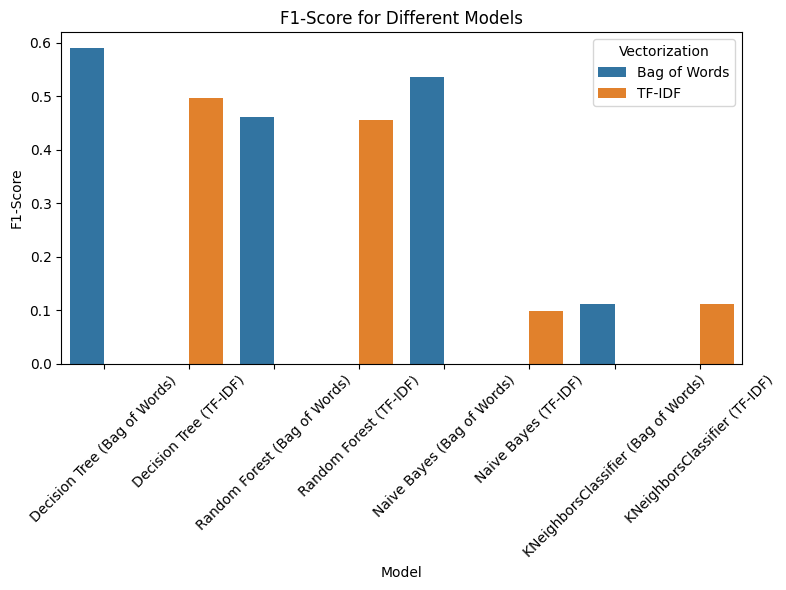

In [51]:
## to generate a f1-score graph for comparison among the models
generate_bar_chart(metrics_df, 'F1-Score')

In [71]:
def generate_confusion_matrix_and_roc_curve(y_true, y_pred_probs, model_name):
    y_pred = (y_pred_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_confusion_matrix.pdf')
    plt.show()
    plt.close()

    roc_auc = roc_auc_score(y_true, y_pred_probs)
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{model_name}, ROC-AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_roc_curve.pdf')
    plt.show()
    plt.close()

In [72]:
def plotRocAuc(model_name,model):
    # Bag of Words
    model.fit(X_train_bow, y_train)
    generate_confusion_matrix_and_roc_curve(y_test, model.predict_proba(X_test_bow)[:, 1], model_name + ' (Bag of Words)')

    # TF-IDF
    model.fit(X_train_tfidf, y_train)
    generate_confusion_matrix_and_roc_curve(y_test, model.predict_proba(X_test_tfidf)[:, 1], model_name + ' (TF-IDF)')

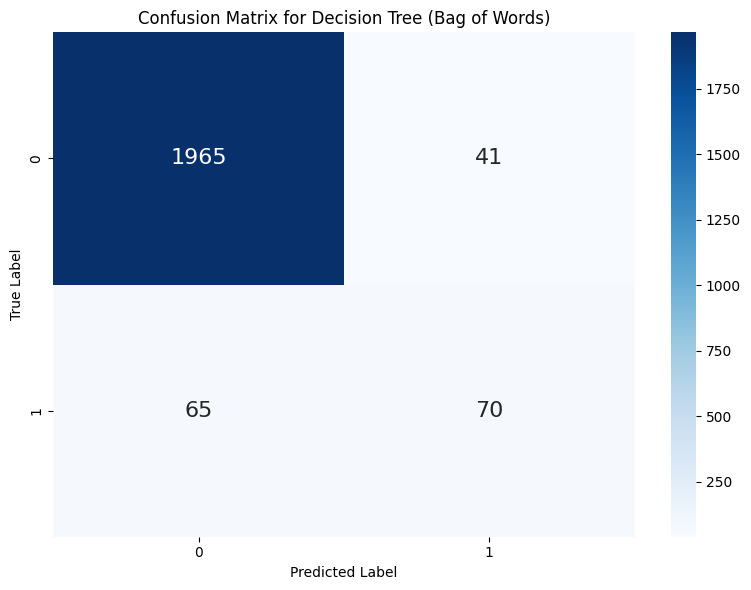

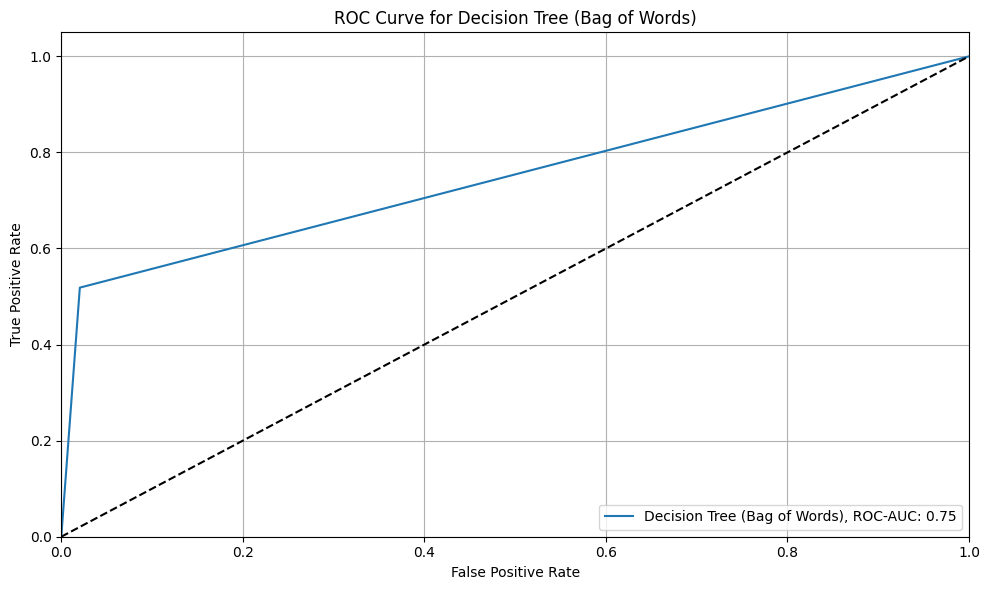

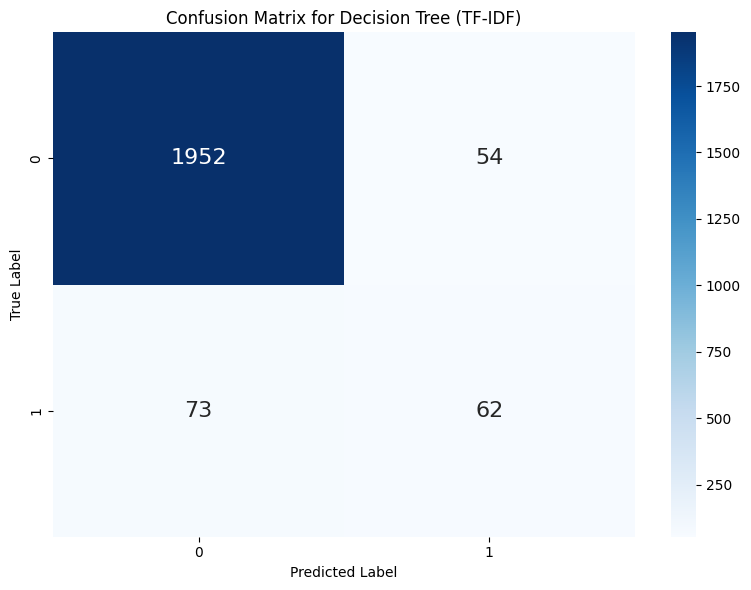

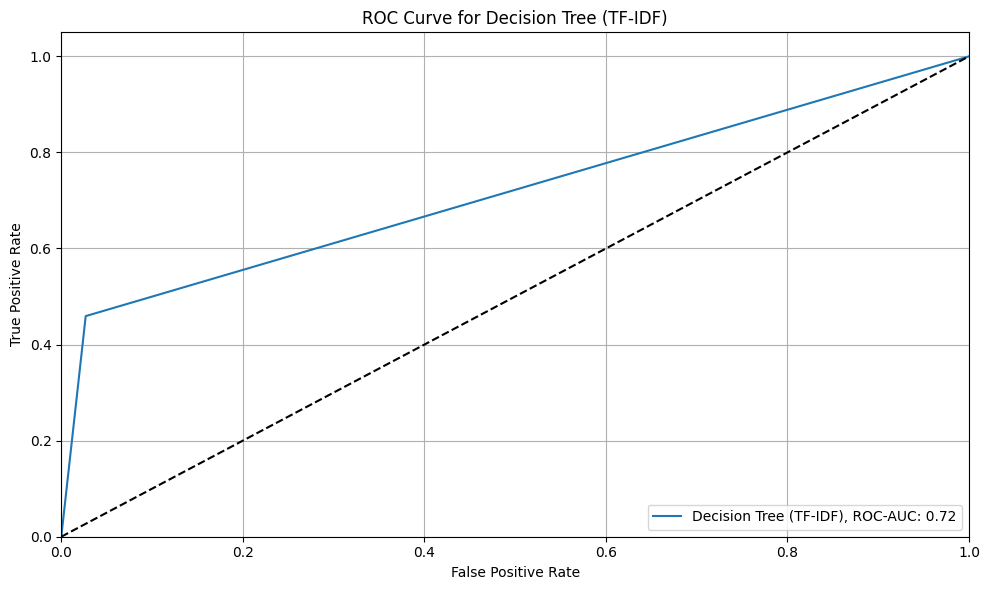

In [73]:
## for decision tree
plotRocAuc("Decision Tree",dt)

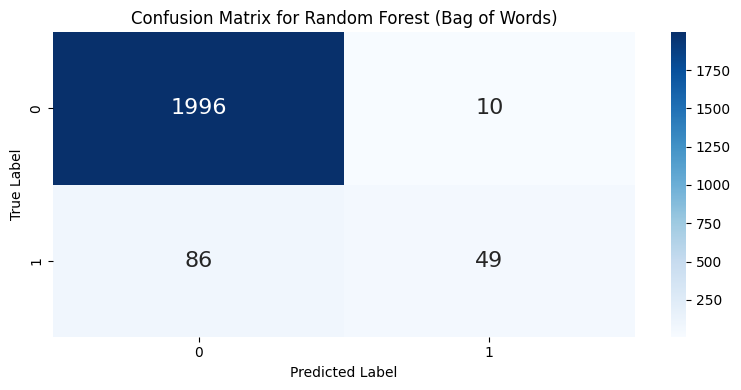

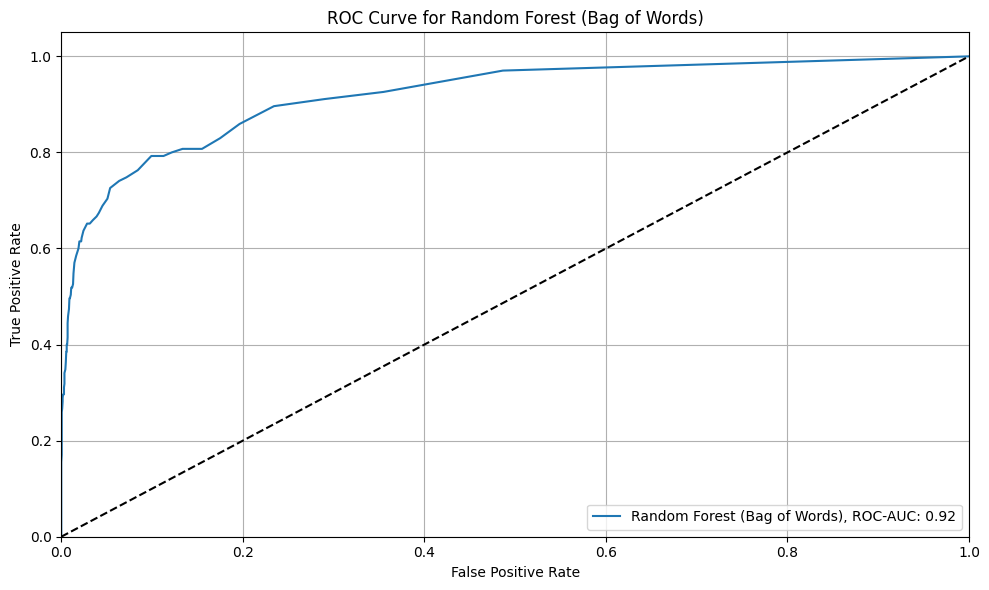

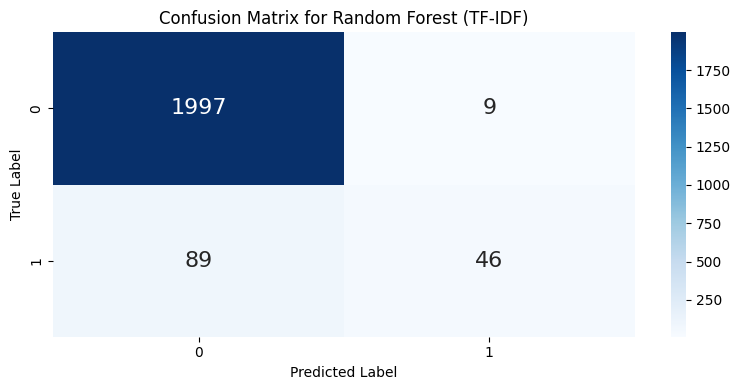

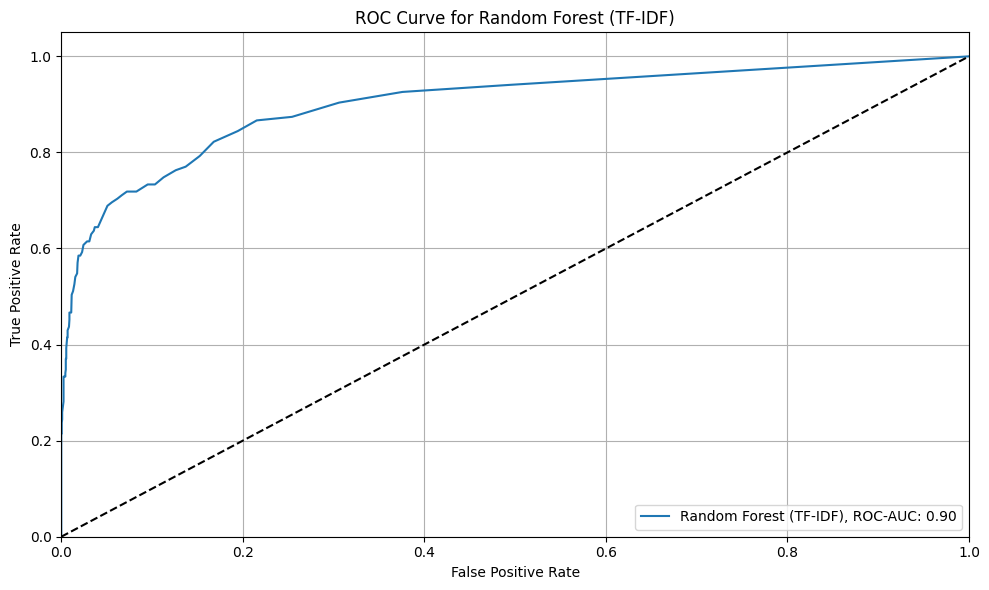

In [58]:
## for random forest
plotRocAuc("Random Forest",rf)


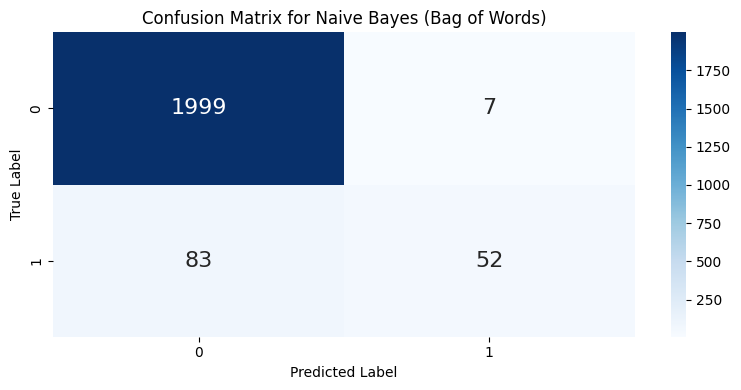

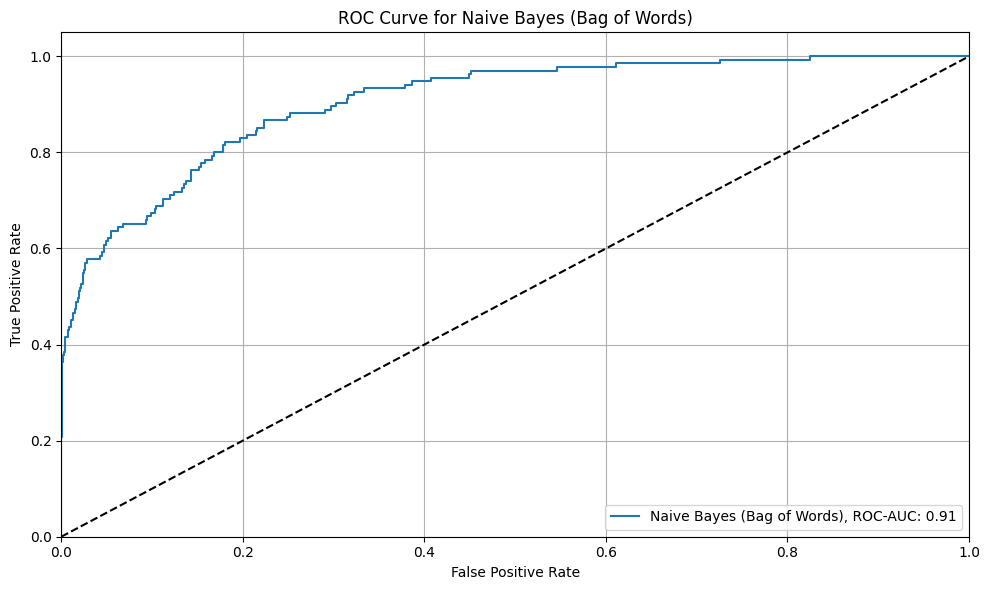

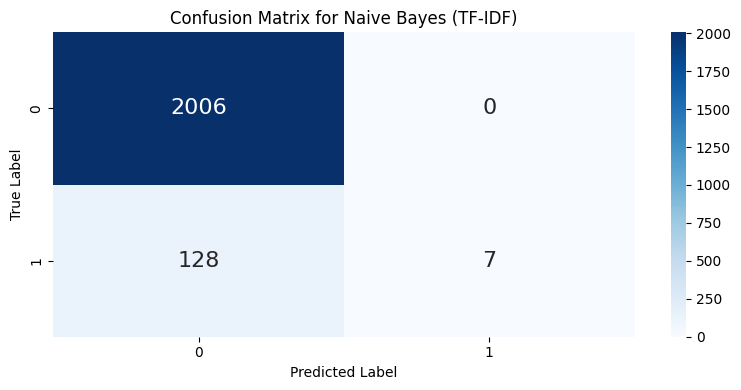

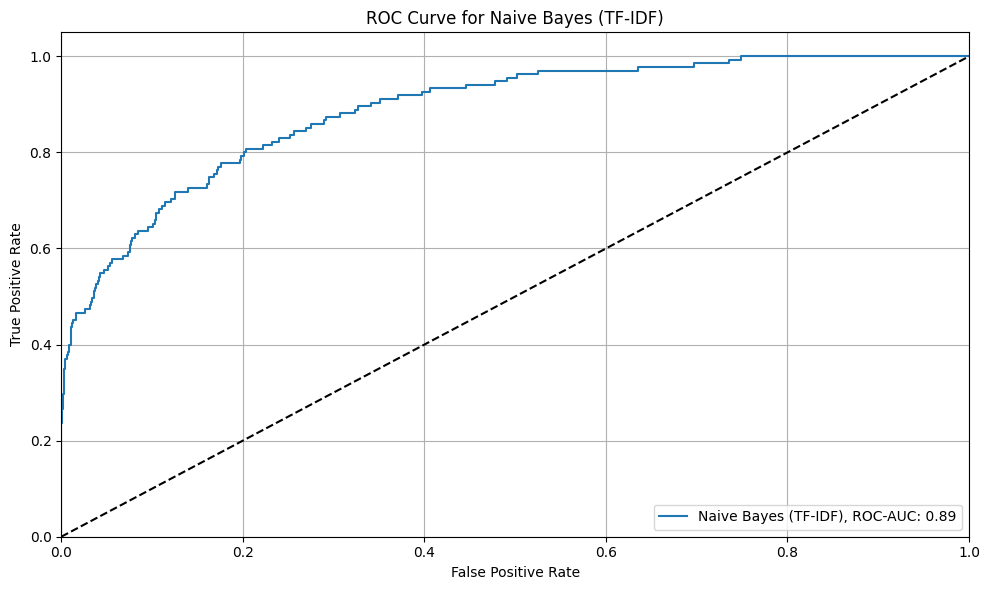

In [59]:
## for Naive Bayes
plotRocAuc("Naive Bayes",nb)

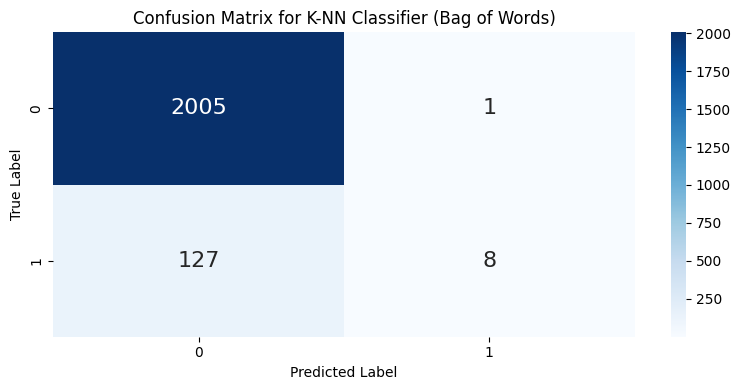

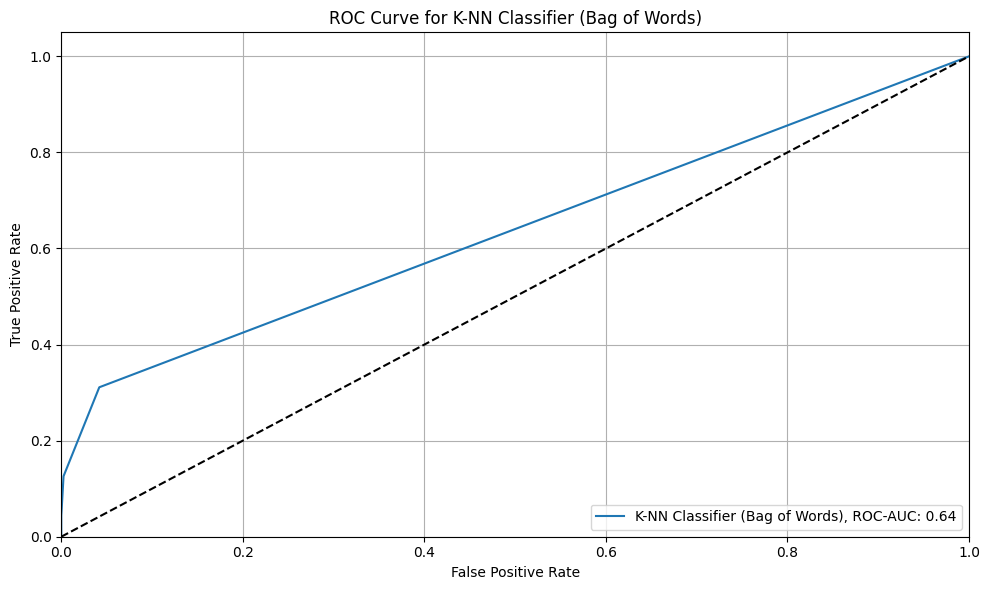

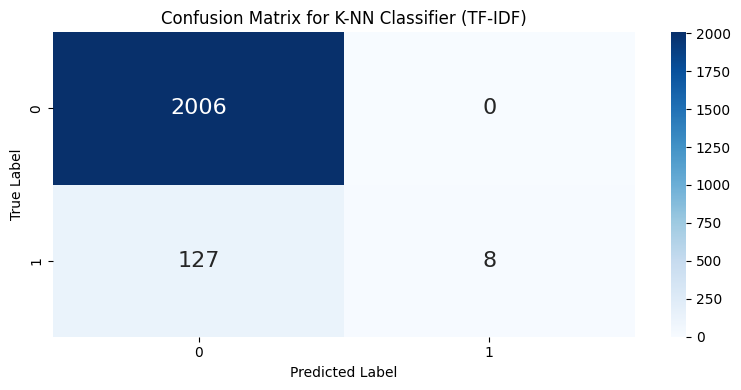

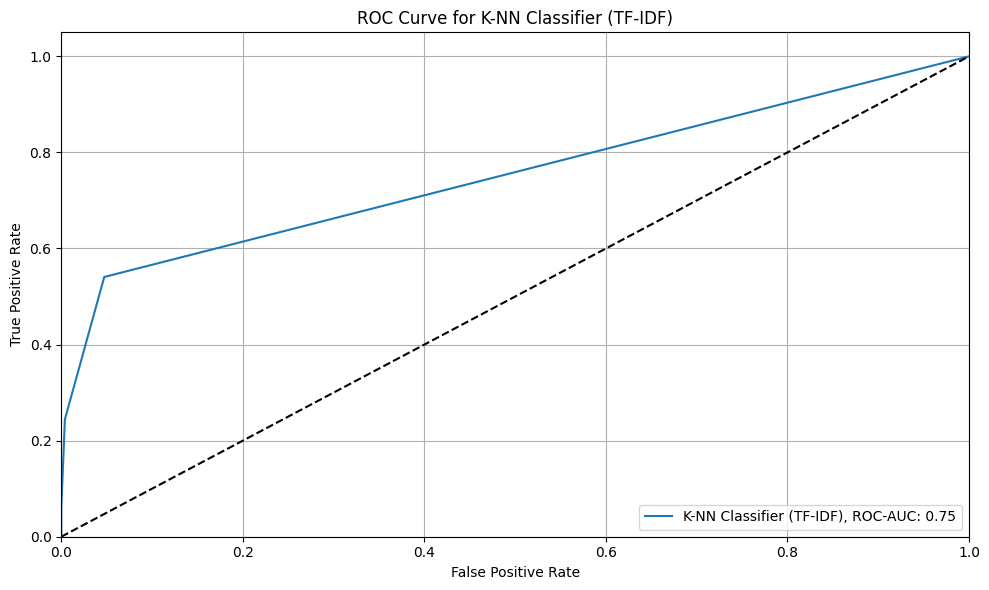

In [60]:
plotRocAuc("K-NN Classifier",knn)

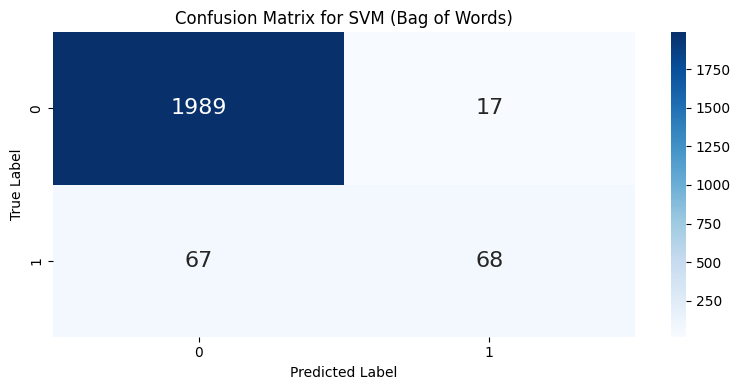

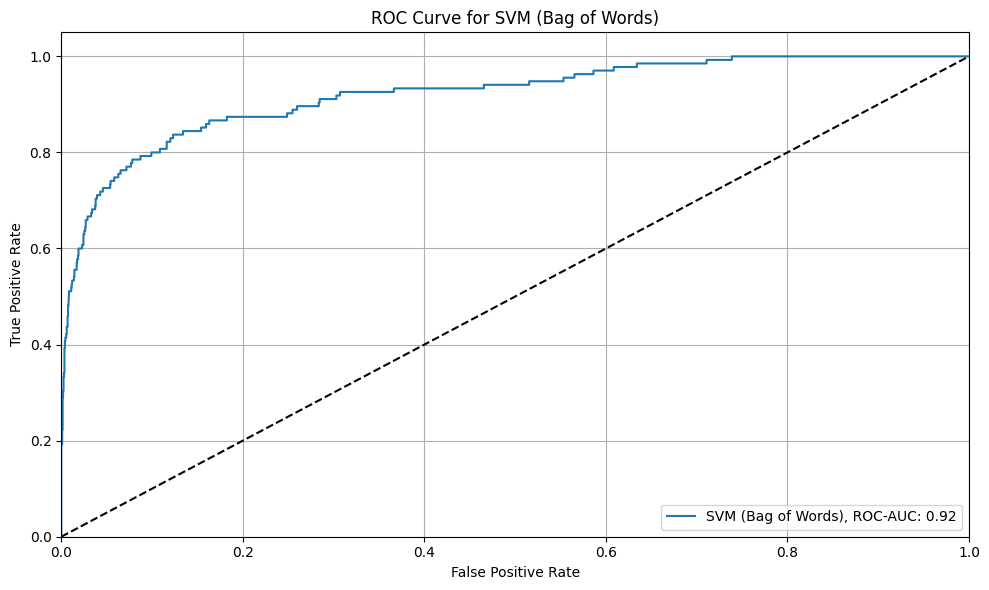

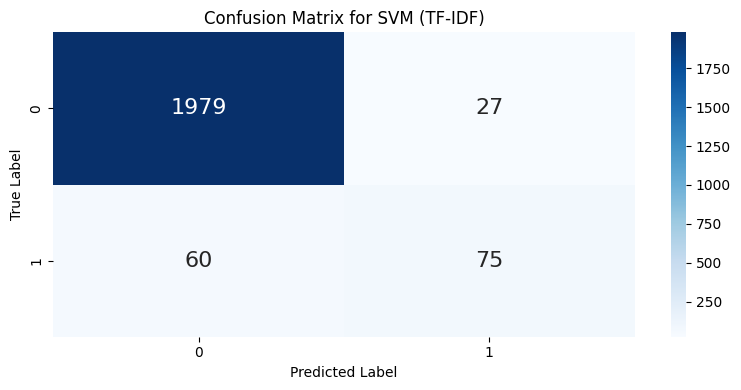

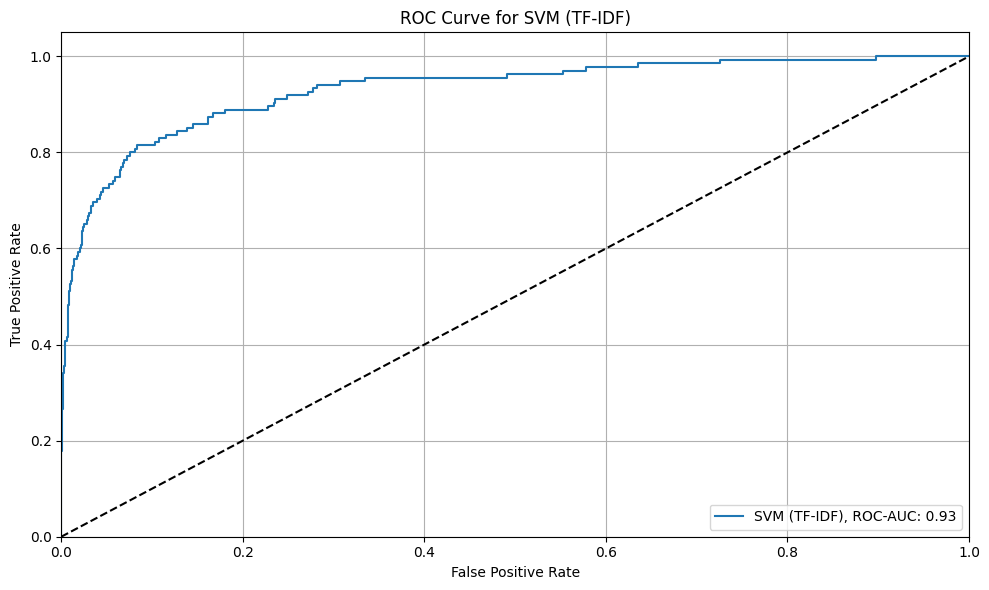

In [61]:
svm=SVC(probability=True)
plotRocAuc("SVM",svm)